In [23]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 96.0 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))   # maps [0,1] → [-1,1]
])

mnist = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(mnist, batch_size=8, shuffle=True)

In [18]:
class Forward:
    def __init__(self, lambda_=1.0): # We only need one param (lambda) and not 2 (theta and sigma) for math reasons (ask me if you want)
        self.lmbd = lambda_

    def mean(self, x_0, t): # Calculate E(X_t) where X_t solution of the OU equation (at time t), we have an explicit formula given x_0.
        return x_0 * torch.exp( - 2 * self.lmbd * t)[:, None, None, None]

    def std(self, t): 
        return torch.exp(- 2 * self.lmbd * t)[:, None, None, None] # To cast to the dimensions of the MNIST tensors [64, 1, 28, 28]
    
    def diffusion_coeff(self, t):
        # t is a tensor [batch], return tensor [batch] too
        return torch.sqrt(torch.tensor(2 * self.lmbd, device=t.device, dtype=t.dtype)) * torch.ones_like(t)

In [6]:
def sample_noisy(x_0, t, sde): # Function used in training to produce the noisy sample x_t | x_0 
    mean = sde.mean(x_0, t)
    std = sde.std(t)
    n_vector = torch.rand_like(x_0) # Generate a standard normal vector of the same dimensions as x_0
    return mean + std * n_vector

def conditional_score(x_0, x_t, t, sde):
    mean = sde.mean(x_0, t)
    std = sde.std(t)
    return -(x_t - mean)/(std ** 2 + 1e-4)

In [53]:
x0, _ = next(iter(loader))  # x0 shape: [8,1,28,28]

# pick random times in [0,1]
t = torch.rand(x0.size(0))
t = t * np.random.uniform(0,5)
# instantiate the OU SDE
sde = Forward(lambda_=1.0)

# sample noisy images
xt = sample_noisy(x0, t, sde)

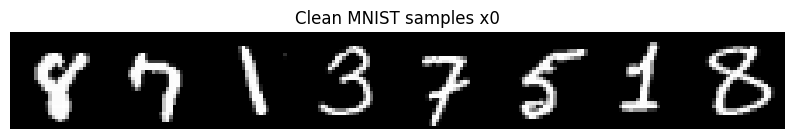

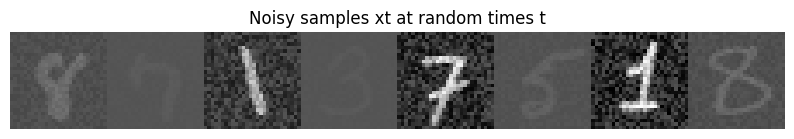

In [54]:
def show_images(x, title):
    x = x.detach().cpu()
    grid = torch.cat([x[i] for i in range(x.size(0))], dim=2)
    plt.figure(figsize=(10,2))
    plt.imshow(grid.squeeze(), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

show_images(x0, "Clean MNIST samples x0")
show_images(xt, "Noisy samples xt at random times t")


In [9]:
import torch.nn as nn
import torch.nn.functional as F

# simple sinusoidal embedding for t
class TimeEmbedding(nn.Module):
    def __init__(self, dim=32):
        super().__init__()
        self.dim = dim
        self.lin = nn.Linear(dim, dim)

    def forward(self, t):
        # t: shape [batch]
        half_dim = self.dim // 2
        emb = torch.exp(
            torch.arange(half_dim, device=t.device) * -(torch.log(torch.tensor(10000.0)) / half_dim)
        )
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return self.lin(emb)  # [batch, dim]


class ScoreNet(nn.Module):
    def __init__(self, time_dim=32):
        super().__init__()
        self.time_mlp = TimeEmbedding(dim=time_dim)

        # Very simple CNN
        self.net = nn.Sequential(
            nn.Conv2d(1 + time_dim, 32, 3, padding=1),  # input: (image + t-channel)
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
        )

    def forward(self, x, t):
        # t → embedding → reshape to image shape
        emb = self.time_mlp(t)          # [batch, time_dim]
        emb = emb[:, :, None, None]     # [batch, time_dim, 1, 1]
        emb = emb.expand(-1, -1, x.size(2), x.size(3))

        # concatenate image + time embedding
        inp = torch.cat([x, emb], dim=1)
        return self.net(inp)


In [10]:
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

sde = Forward(lambda_=1.0)
model = ScoreNet().to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

num_epochs = 5

for epoch in range(num_epochs):
    for x0, _ in loader:
        x0 = x0.to(device)

        # sample random times t ~ Uniform(0,1)
        t = torch.rand(x0.size(0), device=device)

        # sample noisy version xt
        xt = sample_noisy(x0, t, sde)

        # target conditional score
        target = conditional_score(x0, xt, t, sde)

        # model prediction
        pred = model(xt, t)

        # MSE loss
        loss = F.mse_loss(pred, target)

        # update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}: loss = {loss.item():.4f}")


KeyboardInterrupt: 

In [16]:
def sample_reverse_euler_maruyama(model, sde, num_steps=1000, batch_size=16, device="cuda"):
    model.eval()

    T = 1.0
    # time grid from T to 0 (inclusive)
    t = torch.linspace(T, 0.0, num_steps + 1, device=device)  # [num_steps+1]
    x = torch.randn(batch_size, 1, 28, 28, device=device)
    for i in range(num_steps, 0, -1):  # from t_N down to t_1
        t_k = t[i]             # scalar
        t_prev = t[i-1]        # scalar
        dt = t_prev - t_k      # negative

        t_batch = torch.full((batch_size,), t_k, device=device)

        g = (2 * sde.lmbd) ** 0.5 
        g2 = g ** 2 # 2 lambda

        score = model(x, t_batch) # prediction s_theta(x_t, t)

        drift = - sde.lmbd * x - g2[:, None, None, None] * score # Drift term in the reverse SDE

        brownian_step = torch.randn_like(x)

        x = x + drift * dt + g[:, None, None, None] * torch.sqrt(dt.abs()) * noise # This is the Euler Maruyama step, look at the expression

    return x # Approximate sample from p_data

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sde = Forward(lambda_=1.0)
model = model.to(device)  # your trained model

samples = sample_reverse_euler_maruyama(model, sde, num_steps=500, batch_size=16, device=device)

# inverse normalize from [-1,1] back to [0,1] if you used that normalization
samples = (samples.clamp(-1, 1) + 1) / 2.0

import matplotlib.pyplot as plt

def show_batch(x, title="Samples"):
    x = x.detach().cpu()
    grid = torch.cat([x[i] for i in range(x.size(0))], dim=2)
    plt.figure(figsize=(10, 2))
    plt.imshow(grid.squeeze(), cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

show_batch(samples, "Generated MNIST-like samples")


TypeError: 'float' object is not subscriptable